#### Technical setup
> Skip this section

In [71]:
# @formatter:off

In [72]:
%reload_ext autoreload
%autoreload 2
# @formatter:on

# Setup

In [73]:
symbol = 'ETHUSDT'
symbol_k_lines_interval = '1s'
symbol_ask_bid_price_difference = 0.01
price_step_ratio = 0.01

# Ticks

/Users/nikita/Documents/projects/things-team/to-the-moon/ttm-analytics/src/chart/ttm_chart.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(plot.get_xticklabels(), rotation=60)


,timestamp,bid_price,ask_price
0,1677628800000,1605.24,1605.25
1,1677628801000,1605.46,1605.47
2,1677628802000,1605.46,1605.47
3,1677628803000,1605.46,1605.47
4,1677628804000,1605.47,1605.48
...,...,...,...
86395,1677715195000,1665.22,1665.23
86396,1677715196000,1665.23,1665.24
86397,1677715197000,1665.23,1665.24
86398,1677715198000,1665.22,1665.23


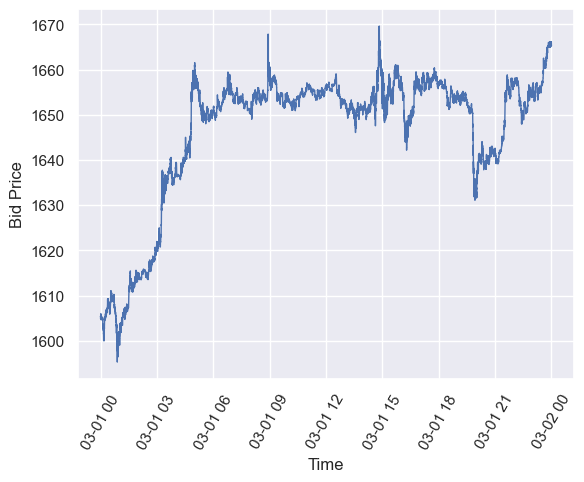

In [74]:
from binance.binance_k_line_loader import load_binance_k_lines
from binance.binance_tick_loader import load_binance_ticks
from chart.ttm_chart import draw_line_chart

k_lines = load_binance_k_lines(f"../../../ttm-data/{symbol}-{symbol_k_lines_interval}-2023-03-01.csv")

ticks = load_binance_ticks(k_lines, symbol_ask_bid_price_difference)

draw_line_chart(ticks.timestamp, ticks.bid_price, name='Bid Price')
ticks

# Simulation

In [75]:
from trade.trade_simulator import TradeSimulator

trade_simulator: TradeSimulator = TradeSimulator()
trade_simulator.process_ticks(ticks, price_step_ratio)

# Results


Closed orders count: 4
Final profit: 0.46000000000026375


/Users/nikita/Documents/projects/things-team/to-the-moon/ttm-analytics/src/chart/ttm_chart.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(plot.get_xticklabels(), rotation=60)


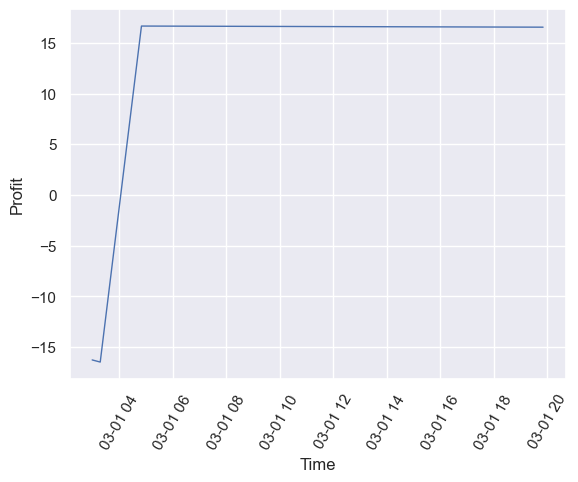

In [76]:
from trade.trade_simulator_order import TradeSimulatorOrder

closed_orders: [TradeSimulatorOrder] = trade_simulator.get_closed_orders()
profit: float = trade_simulator.get_profit()

draw_line_chart(
    list((closed_order.open_tick.timestamp for closed_order in closed_orders)),
    list((closed_order.get_profit() for closed_order in closed_orders)),
    name='Profit')

print(f"=========")
print(f"Closed orders count: {len(closed_orders)}")
print(f"Final profit: {profit}")
print(f"=========")
